In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [33]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ SUCCESS: GPU is available: {gpus[0].name}")
else:
    print("❌ WARNING: You are using CPU. Go to Runtime -> Change runtime type -> T4 GPU")

✅ SUCCESS: GPU is available: /physical_device:GPU:0


In [34]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(42)

#Loading data

In [35]:
dataset_path = '/content/drive/MyDrive/Mushroom-project/Sri Lankan mushroom species.v3i.folder'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)


In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    f'{dataset_path}/train',
    shuffle = True,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    f'{dataset_path}/valid',
    shuffle = False,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f'{dataset_path}/test',
    shuffle = False,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

class_names = train_ds.class_names
print("\n\nMushroom classes:")
for mushroom_class in class_names:
    print(f'\t{mushroom_class}')

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 1251 files belonging to 13 classes.
Found 122 files belonging to 13 classes.
Found 61 files belonging to 13 classes.


Mushroom classes:
	Idalolu
	Muthu beli bimmal
	boththam hathu
	goma hathu
	heenvali hathu
	kotan hathu
	kurulu thuda bimmal
	leena hathu
	mahaveli hathu
	nayi hathu
	piduru hathu
	rathu hathu
	uru hathu


#Data Augmentation

In [37]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomContrast(0.25)
])

#Model Architecture

In [38]:
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape = IMG_SIZE + (3,),
    include_top = False,
    weights = 'imagenet'
)

base_model.trainable = False

In [39]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs, outputs)

In [40]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [42]:
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = 40,
    callbacks = [early_stopping]
)

Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.1751 - loss: 2.5901 - val_accuracy: 0.5328 - val_loss: 1.6202
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5094 - loss: 1.5639 - val_accuracy: 0.6803 - val_loss: 1.2362
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6507 - loss: 1.1795 - val_accuracy: 0.7131 - val_loss: 1.0382
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7139 - loss: 0.9518 - val_accuracy: 0.7377 - val_loss: 0.9691
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7537 - loss: 0.8095 - val_accuracy: 0.7377 - val_loss: 0.9072
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7991 - loss: 0.7139 - val_accuracy: 0.7377 - val_loss: 0.8443
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7955 - loss: 0.6782 - val_accuracy: 0.7377 - val_loss: 0.8053
Epoch 8/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8316 - loss: 0.6083 - val_accuracy: 0.7459 -

#Evaluation

In [43]:
pred = model.predict(test_ds)
y_pred = np.argmax(pred, axis=1)

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 996ms/step


In [44]:
y_true = []

for images, labels in test_ds:
  y_true.extend(labels.numpy())



- Classification report

In [45]:
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.67      0.67      0.67         3
           2       0.67      1.00      0.80         2
           3       1.00      0.75      0.86        12
           4       0.60      0.75      0.67         4
           5       0.86      0.86      0.86         7
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      0.50      0.67         4
           9       1.00      1.00      1.00         7
          10       0.57      1.00      0.73         4
          11       1.00      1.00      1.00         5
          12       0.57      1.00      0.73         4

    accuracy                           0.82        61
   macro avg       0.84      0.85      0.82        61
weighted avg       0.87      0.82      0.82        61



- Confusion matrix

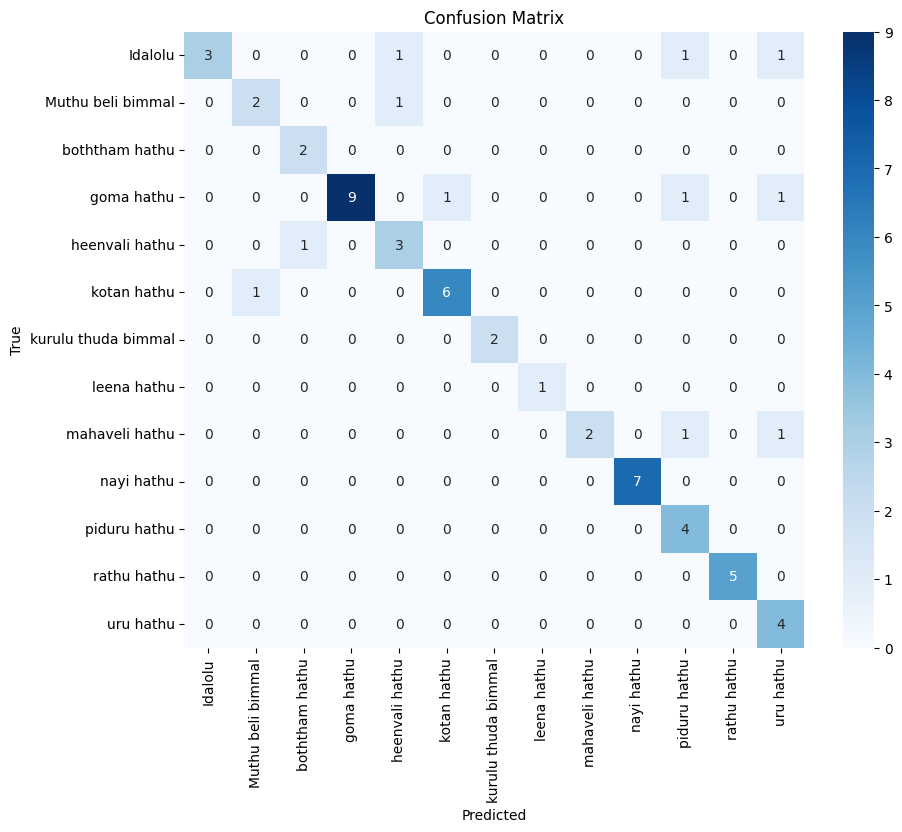

In [46]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

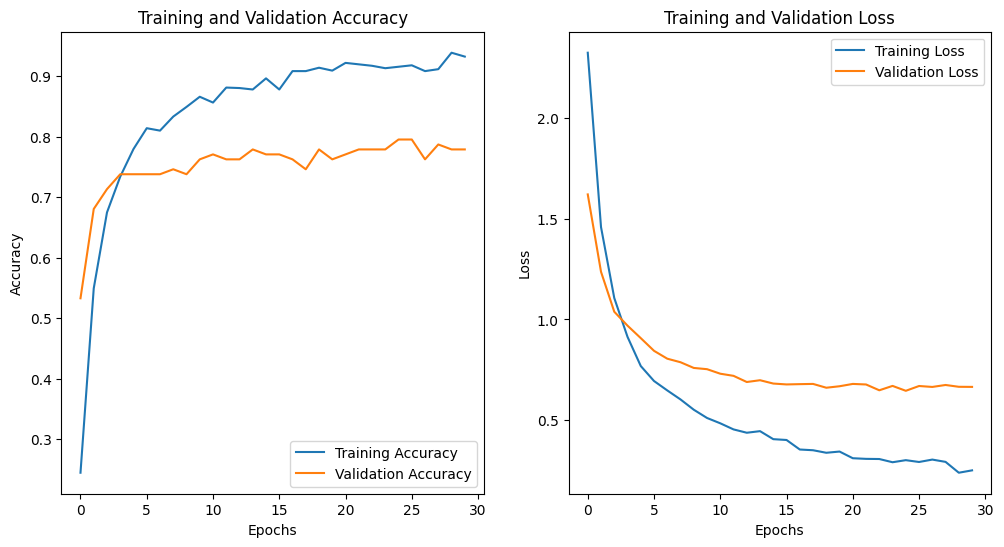

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# 2. Setup the plot
plt.figure(figsize=(12, 6))

# --- Plot Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [48]:
import tensorflow as tf

# 1. Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 2. Save the .tflite file
with open('mushroom_model.tflite', 'wb') as f:
    f.write(tflite_model)

# 3. Save your labels (mushroom names) to a text file
# Ensure 'class_names' matches the variable holding your mushroom types
with open('labels.txt', 'w') as f:
    for name in class_names:
        f.write(name + '\n')

print("✅ Download 'mushroom_model.tflite' and 'labels.txt' to your computer.")

Saved artifact at '/tmp/tmpl4jo2xbs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_547')
Output Type:
  TensorSpec(shape=(None, 13), dtype=tf.float32, name=None)
Captures:
  136496927900496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136496927908560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136494252500432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136496882685840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136496927904528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136494252498512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136494252500240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136494252501008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136496927901840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136494252499856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136494252